
# ADVANCED TOPIC MODELLING 


In this tutorial we are going perform topic modelling on a corpus of news from newspapers of various countries collected with the keyword "Artificial Intelligence'. We will use GENSIM library which is a  useful library for  natural language processing and topic modelling : https://radimrehurek.com/gensim/index.html. 

We will start with a cleaned,  pre-processed and tokenized list of documents, select the best model, decide on the number of topics and explore the word-topic and topic-document distibutions to extract clean, seggregating and meaningful topics. We will use two unsupervised machine learning algorithms, specifically latent dirichlet allocation (LDA) and non-negative matrix factorisation (NMF), to explore the topics  in full.


First you need to import the following packages (assuming that they are already installed). However, for this tutorial you do  not have to worry about this, as they already come with the Docker container. You even don't need Python to be installed in your computer to execute the commands. 

Yet, try to become a Python literate if you want to personalize the script and develop your own methods.

In [1]:
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')
import pandas as pd, os, json, numpy as np, re, textacy, pickle, string, re, nltk,  spacy, flashtext, contractions, unicodedata
from datetime import datetime; from dateutil import parser; 
from collections import Counter; from pprint import pprint
import textacy; from textacy import preprocessing, ke, vsm, tm, text_utils, Corpus, doc
from cytoolz import itertoolz
import joblib; from tabulate import tabulate; from time import time
from flashtext import KeywordProcessor
from urllib.parse import urlparse
from gensim.models.wrappers import LdaMallet; from gensim.models import LdaModel, LsiModel,  HdpModel, CoherenceModel
import gensim; from gensim.corpora import Dictionary;  from gensim import corpora
import sklearn;from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation,  TruncatedSVD
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from nltk.stem import WordNetLemmatizer
from IPython.display import display
import seaborn as sns, matplotlib.pyplot as plt, matplotlib.image as mpimg, base64, io, os,  matplotlib.colors as mcolors
%matplotlib inline
sns.set()  # defines the style of the plots 
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as patches
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.manifold import TSNE
import bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 1. Preparing your texts for topic modelling

The quality of the topics depends heavily on the quality of text collection, pre-processing, a good corpus vocabulary selection strategy.  All these steps need to be undertaken before topic modelling. This tutorial will proceed to topic modelling with a clean, preprocessed, and tokenized list of documents. However, to demonstrate how this is done, I'll provide a short example for how to do this quickly. Yet, quick is dirty and for a serious research face the challenge of interactively cleaning your text. For this, you can refer to the Jupyter notebook bnamed 'cleaning'.



### 1.1 Start from scratch (quick and dirty)

### 1.1.1 Import the raw documents, preprocess and tokenize them. 

a. pd.read_csv('jap2.csv') imports the list of documents as a dataframe. You can upload your own data in csv form to the Jupyter folder you prepared and do your own analysis. Here , we import them and name as 'documents'.

b. Gensim utils.simple_preprocess method does the basic preprocessing and tokenizing for you. For processing multiple documents, I defined a function named 'docs_to_words(docs)'.

c. To preprocess and tokenize your documents, just replace 'doc's with the name of the column containing the text in your data, i.e. for the body of the text  documents.Content, for the titles documents.Title. Of course this dependent on how you named these columns in your csv. These are names of the columns for my data. Yours could be differernt. So be carefull. 
The name for processed data is **'terms'** , so do not forget this when follwoing through the script. 

d. Finally, if you want to see what you get in the end, you can print first  document.(not required, only a demo here)


In [2]:
from gensim import utils
documents = pd.read_csv('jap2.csv')#a.

def docs_to_words(docs):#b.
    for doc in docs:
        yield(utils.simple_preprocess(str(doc), deacc=True))  # deacc=True removes punctuations

w_list = list(docs_to_words(documents.Content))#c.
print(w_list[:1])#d.

[['robots', 'aren', 'replacing', 'everyone', 'but', 'quarter', 'of', 'jobs', 'will', 'be', 'severely', 'disrupted', 'as', 'artificial', 'intelligence', 'accelerates', 'the', 'automation', 'of', 'existing', 'work', 'according', 'to', 'new', 'brookings', 'institution', 'report', 'thursday', 'report', 'from', 'the', 'washington', 'think', 'tank', 'says', 'roughly', 'million', 'americans', 'hold', 'jobs', 'with', 'high', 'exposure', 'to', 'automation', 'meaning', 'at', 'least', 'percent', 'of', 'their', 'tasks', 'could', 'soon', 'be', 'performed', 'by', 'machines', 'using', 'current', 'technology', 'among', 'those', 'most', 'likely', 'to', 'be', 'affected', 'are', 'cooks', 'waiters', 'and', 'others', 'in', 'food', 'services', 'short_haul', 'truck', 'drivers', 'and', 'clerical', 'office', 'workers', 'that', 'population', 'is', 'going', 'to', 'need', 'to', 'upskill', 'reskill', 'or', 'change', 'jobs', 'fast', 'said', 'mark', 'muro', 'senior', 'fellow', 'at', 'brookings', 'and', 'lead', 'auth

### 1.1.2 Creating Bigram and Trigram Models
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: severely_disrupted'; 'artificial_intelligence' etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [3]:
# Build the bigram and trigram models

bigram = gensim.models.Phrases(w_list, min_count=5, threshold=100) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[w_list], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(bigram_mod[w_list[0]])

['robots', 'aren', 'replacing', 'everyone', 'but', 'quarter', 'of', 'jobs', 'will', 'be', 'severely_disrupted', 'as', 'artificial_intelligence', 'accelerates', 'the', 'automation', 'of', 'existing', 'work', 'according', 'to', 'new', 'brookings_institution', 'report', 'thursday', 'report', 'from', 'the', 'washington', 'think_tank', 'says', 'roughly', 'million', 'americans', 'hold', 'jobs', 'with', 'high', 'exposure', 'to', 'automation', 'meaning', 'at', 'least', 'percent', 'of', 'their', 'tasks', 'could', 'soon', 'be', 'performed', 'by', 'machines', 'using', 'current', 'technology', 'among', 'those', 'most', 'likely', 'to', 'be', 'affected', 'are', 'cooks', 'waiters', 'and', 'others', 'in', 'food', 'services', 'short_haul', 'truck_drivers', 'and', 'clerical', 'office', 'workers', 'that', 'population', 'is', 'going', 'to', 'need', 'to', 'upskill', 'reskill', 'or', 'change', 'jobs', 'fast', 'said', 'mark', 'muro', 'senior_fellow', 'at', 'brookings', 'and', 'lead', 'author', 'of', 'the', '

### 1.1.3. Remove Stopwords, Make Bigrams and Lemmatize
The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [4]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
from spacy.lang.en.stop_words import STOP_WORDS

def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in STOP_WORDS] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

'''
spacy lemmatzation takes very long time, hence do this after the tutorial,
we will lemmatize only nouns with nltk wordnet lemmatizer

starts here:
########################################
!spacy download en_core_web_sm


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
#####################################    
'''

# Remove Stop Words
data_words_nostops = remove_stopwords(w_list)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

''' 
we are using nltk wordnet lemmatizer, for quicker but coarser results

'''

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

lms = [[lemmatizer.lemmatize(t) for t in doc] for doc in data_words_bigrams]

'''
for better results, use the spacy function we have defined, takes longer but better results

nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
lsm = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

'''

'\nspacy lemmatzation takes very long time, hence do this after the tutorial,\nwe will lemmatize only nouns with nltk wordnet lemmatizer\n\nstarts here:\n########################################\n!spacy download en_core_web_sm\n\n\ndef lemmatization(texts, allowed_postags=[\'NOUN\', \'ADJ\', \'VERB\', \'ADV\']):\n    """https://spacy.io/api/annotation"""\n    texts_out = []\n    for sent in texts:\n        doc = nlp(" ".join(sent)) \n        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])\n    return texts_out\n#####################################    \n'

' \nwe are using nltk wordnet lemmatizer, for quicker but coarser results\n\n'

"\nfor better results, use the spacy function we have defined, takes longer but better results\n\nnlp = spacy.load('en', disable=['parser', 'ner'])\n\n# Do lemmatization keeping only noun, adj, vb, adv\nlsm = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])\n\n"

##  2 Transform your text collection to a document term matrix
This tutorial assumes that the audience is already familar with the basic concepts of text analysis such as cleaning, preprocessing and tokenizing the text. Hence the example data provided in this tutorial contains list of lists where each list represents a document containing preprocessed and clean tokens. List of documents makes the entire corpus. Hence, to be able to replicate the example in this tutorial, the reader needs to start with such data, not the raw texts. You can use the procedure expalined in 1.1. but I advise you to do more rigorous cleaning to get good quality topics. After importing the data we will have an overview of the corpus by looking at the most frequent words. This can help us to detect if texts require further cleaning and\or preprocessing. The explanation of what each command does is written in the ghosted text. 

Now, we will represent our corpus as a bag of words or document term matrix. In other words, we will convert words into numbers and represent each document as a vector of terms. This process is named as 'vectorization'.



### 2.1 Explore your corpus

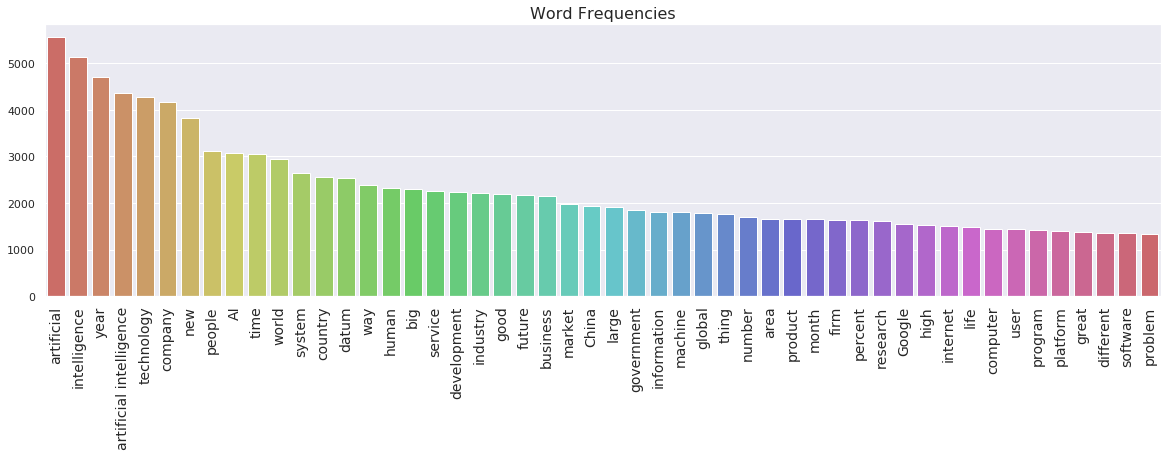

In [5]:
'''
this is for the above
terms= [[i for i in li] for li in lms]
'''
##you can use  cleaner data:

with open ('yak_vector', 'rb') as fp:# posrank terms
    terms = pickle.load(fp)#prnk yakws100 scak yak10 sr bot yak10

terms= [[i[0] for i in li] for li in terms]#for example prnk

############################this is for the tokenized sgr#############################################
terms_dict = Counter(np.concatenate(terms))#count words
terms_df = pd.DataFrame.from_dict(terms_dict, orient='index')#dict to dataframe
terms_df.rename(columns={0: 'count'}, inplace=True)#chnage the name of column
terms_df.sort_values('count', ascending=False, inplace=True)#sort

def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(terms_df)#changew raw
ax.set_title("Word Frequencies", fontsize=16);

### 2.2. Normalize texts: add more stopwords, add your own stopwords and lowercase the texts

The act of text normalization should be optional and applied carefully because the operation is destructive in that it removes information. Case, punctuation, stopwords, and varying word constructions are all critical to understanding language. Some models may require indicators such as case. For example, a named entity recognition classifier, because in English, proper nouns are capitalized.


In [6]:
new_stop_words= {'people', 'subject', 'p.m.', 'early', 'time', 'year', 'use', 'not', 'would', 'say', 'said','could',  'be', 'know', 
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see',
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right',
                   'line', 'even', 'also', 'may', 'take', 'come' ,  'able',  'area','case',  'company','country',
                   'day','decade','example','future','head','high','January','lot','month','need','number','number',
                   'people','percent','place','result','thing','time','Tuesday','use','way','week',   'world','year',
                   'artificial intelligence', 'artificial', 'intelligence','April', 'August', 'century',
                   'date', 'December', 'difficult', 'dozen', 'February','form','great','history','hour','hundred',
                  'July','June','kilometer','kind','late','long','March','million','million','minute',
                   'November','October','part','past','point','previous', 'real','recent',
                   'role','September','term','thousand','today', 'January', 'May', 'Monday', 'Wednesday',
                  'Thursday', 'Friday', 'Saturday', 'Sunday', 'ush','ush(function', 'IST', 'ist'}

stop_words =  set(new_stop_words).union(set(STOP_WORDS))


lms = [[word.lower() for word in doc if word not in stop_words] for doc in terms]     

### 2.3 Make a dictionary 

A dictionary is a mapping of words with an id for each word. It maps the vocabulary of the corpus. Here we need to make some decisions, inclusion of too frequent or rare words may not help distinguishing the topics, increase computing time, and bias our analysis, hence it might be a good idea to exclude them. In the example below, we decide to filter the words occuring in more than 95 % of the documents and in less than 25 documents. You can change these by changing the' abo' and 'belo' in the below script.



In [7]:
abo=.90 #filter if term appears in more than 90% of the docs
belo=30#filter if term appears in less than 30  docs
dictionary = Dictionary(documents=lms)
print("Found {} words.".format(len(dictionary.values())))
dictionary.filter_extremes(no_above=abo, no_below=belo)
dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Found 355977 words.
Left with 5157 words.


In [8]:
# if you want to see the word-id mappings than unghost the follwoing:
dictionary.token2id

{'addition': 0,
 'administrative': 1,
 'advance': 2,
 'amazon': 3,
 'americans': 4,
 'anxiety': 5,
 'ap photo': 6,
 'aren': 7,
 'aren t': 8,
 'assistant': 9,
 'associate': 10,
 'author': 11,
 'automation': 12,
 'autonomous': 13,
 'belt': 14,
 'book': 15,
 'boston': 16,
 'bowl': 17,
 'business': 18,
 'camera': 19,
 'center': 20,
 'chain': 21,
 'change': 22,
 'chicago': 23,
 'city': 24,
 'class': 25,
 'clear': 26,
 'computerized': 27,
 'concierge': 28,
 'consulting': 29,
 'conversation': 30,
 'cook': 31,
 'cooking': 32,
 'county': 33,
 'creativity': 34,
 'crisis': 35,
 'current': 36,
 'datum': 37,
 'delivery': 38,
 'demand': 39,
 'desk': 40,
 'digital': 41,
 'doubt': 42,
 'driver': 43,
 'eager': 44,
 'economic': 45,
 'economist': 46,
 'economy': 47,
 'education': 48,
 'effect': 49,
 'electronic': 50,
 'emotional': 51,
 'expansion': 52,
 'exposure': 53,
 'facial': 54,
 'fellow': 55,
 'file': 56,
 'file photo': 57,
 'financial': 58,
 'firm': 59,
 'flagship': 60,
 'floor': 61,
 'food': 62,


### 2.4 Vectorize  (make a document term matrix, bag of words)

Gensim’s vectorizer is called doc2bow. To use doc2bow, we created a Gensim Dictionary mapping tokens to indices based on observed order . The dictionary object can be loaded or saved to disk, and implements a doc2bow library that accepts a pretokenized document and returns a sparse matrix of (id, count) tuples where the id is the token’s id in the dictionary. Gensim doc2bow produces the DTM as a sparse matrix, f you want to convert this to a dense matrix, use the corpus2dense function. For example, in the code below, to calculate the sparsity of the matrix we transformed the matrix from sparse to dense.

Many model families suffer from “the curse of dimensionality”; as the feature space increases in dimensions, the data becomes more sparse and less informative to the underlying decision space. Text normalization reduces the number of dimensions, decreasing sparsity. Check the sparsity level below, and go to 2.3 to tune the word inclusion and/or exclusion parameters if neccessary 
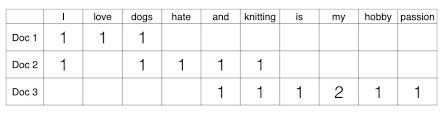



In [9]:
#dictionary.save('dictionary')#save dictionary
corpus = [dictionary.doc2bow(text) for text in lms]
#corpora.MmCorpus.serialize('corpus.mm', corpus)  # save corpus to disk

#the remaining part is only for calculating the sparsity of the corpus, not requierd for topic modeling
from gensim import matutils
data_dense =gensim.matutils.corpus2dense(corpus, len(dictionary.values()) )
# Gensim corpus is a list of list and each list is a document. 
#Tuples include token-id from dictionary and frequency of that token in the document.

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  2.0494410174757465 %


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency). For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

Human readable format of corpus (term-frequency): 

In [10]:
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus][:1]

[[('addition', 1),
  ('administrative', 1),
  ('advance', 1),
  ('amazon', 1),
  ('americans', 1),
  ('anxiety', 1),
  ('ap photo', 1),
  ('aren', 1),
  ('aren t', 1),
  ('assistant', 1),
  ('associate', 1),
  ('author', 1),
  ('automation', 1),
  ('autonomous', 1),
  ('belt', 1),
  ('book', 1),
  ('boston', 1),
  ('bowl', 1),
  ('business', 1),
  ('camera', 1),
  ('center', 1),
  ('chain', 1),
  ('change', 1),
  ('chicago', 1),
  ('city', 1),
  ('class', 1),
  ('clear', 1),
  ('computerized', 1),
  ('concierge', 1),
  ('consulting', 1),
  ('conversation', 1),
  ('cook', 1),
  ('cooking', 1),
  ('county', 1),
  ('creativity', 1),
  ('crisis', 1),
  ('current', 1),
  ('datum', 1),
  ('delivery', 1),
  ('demand', 1),
  ('desk', 1),
  ('digital', 1),
  ('doubt', 1),
  ('driver', 1),
  ('eager', 1),
  ('economic', 1),
  ('economist', 1),
  ('economy', 1),
  ('education', 1),
  ('effect', 1),
  ('electronic', 1),
  ('emotional', 1),
  ('expansion', 1),
  ('exposure', 1),
  ('facial', 1),
  

##  3 Topic modelling 


Can be described as a method of uncovering hidden structure in a collection of texts. Let’s define topic modeling in more practical terms.

**Definitions:**

C: collection of documents containing N texts.

V: vocabulary (the set of unique words in the collection)

**Dimensionality Reduction**
Topic modeling is a form of dimensionality reduction. Rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in V}, we can represent the text in its topic space as {Topic_i: weight(Topic_i, T) for Topic_i in Topics}. Notice that we’re using Topics to represent the set of all topics.

**Unsupervised Learning**
Topic modeling can be easily compared to clustering. As in the case of clustering, the number of topics, like the number of clusters, is a hyperparameter. By doing topic modeling we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a certain weight.

**A Form of Tagging**
If document classification is assigning a single category to a text, topic modeling is assigning multiple tags to a text. A human expert can label the resulting topics with human-readable labels and use different heuristics to convert the weighted topics to a set of tags.

**Why is Topic Modeling useful?**
There are several scenarios when topic modeling can prove useful. Here are some of them:

**Text classification** – Topic modeling can improve classification by grouping similar words together in topics rather than using each word as a feature

**Recommender Systems** – Using a similarity measure we can build recommender systems. If our system would recommend articles for readers, it will recommend articles with a topic structure similar to the articles the user has already read.

**Uncovering Themes in Texts** – Useful for detecting trends in online publications for example


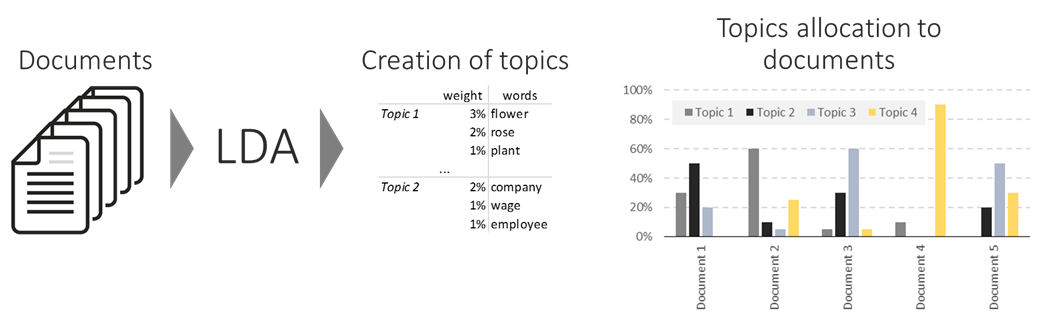

### 3.1 Topic Modeling Algorithms

There are several algorithms for doing topic modeling. The most popular ones include

**LDA – Latent Dirichlet Allocation** – The one we’ll be focusing in this tutorial. Its foundations are Probabilistic Graphical Models

**Hierarchical Dirichlet process (HDP)** Unlike its finite counterpart, latent Dirichlet allocation, the HDP topic model infers the number of topics from the data.

**LSA or LSI** – Latent Semantic Analysis or Latent Semantic Indexing – Uses Singular Value Decomposition (SVD) on the Document-Term Matrix. Based on Linear Algebra

**NMF – Non-Negative Matrix Factorization** – Based on Linear Algebra

Here are some things all these algorithms have in common:

The number of topics (n_topics) as a parameter. None of the algorithms can infer the number of topics in the document collection.
All of the algorithms have as input the Document-Word Matrix (or Document-Term Matrix). DWM[i][j] = The number of occurrences of word_j in document_i

All of them output 2 matrices: WTM (Word Topic Matrix) and TDM (Topic Document Matrix). The matrices are significantly smaller and the result of their multiplication should be as close as possible to the original DWM matrix

### 3.2 Model Selection and Evaluation: 
Topic Modelling algorithms are attractive as they bring structure to otherwise unstructured text data, but topics are not guaranteed to be well interpretable and coherent. There are almost no rigorous theoretical guarantees or guaranteed algorithms for getting good topics. Deciding on the best algorithm and getting good quality topics is an iterative exercise requiring multi interpretative steps dependent upon many criteria. There are some decision tools, but selecting the model and number of topics is craft by applying these tools rather than technique. Some of these tools:

#### 3.2.1 Explore with HDP

HDP is an extension of LDA, designed to address the case where the number of mixture components (the number of "topics" in document-modeling terms) is not known apriori.

For HDP (applied to document modeling), one also uses a Dirichlet process to capture the uncertainty in the number of topics. So a common base distribution is selected which represents the countably-infinite set of possible topics for the corpus, and then the finite distribution of topics for each document is sampled from this base distribution.


As far as pros and cons, HDP has the advantage that the maximum number of topics can be unbounded and learned from the data rather than specified in advance. I suppose though it is more complicated to implement, and unnecessary in the case where a bounded number of topics is acceptable.

In this context,we will use it to have an intuition about the possible number of topics and if the topics makes sense. Calculating the sum of weights in a topic and sorting them from highest to lowest  can give us an idea about the weights of topics. When we see incremental decline stabilizes, this can be a heuristic about number of topics. We can also check the topics to see if they are human interpretable. 


In [11]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
CoherenceModel(model=hdpmodel, texts=lms, dictionary=dictionary, coherence='c_v').get_coherence()

#to choose the opt number of topics check the weights set up a threshold (i.e 01)
def topic_prob_extractor(hdpmodel):
    shown_topics = hdpmodel.show_topics(num_topics=100, formatted=False)
    topics_nos = [x[0] for x in shown_topics ]
    weights = [ sum([item[1] for item in shown_topics[topicN][1]]) for topicN in topics_nos]

    return pd.DataFrame({'topic_id' : topics_nos, 'weight' : weights})

topic_prob_extractor(hdpmodel)

0.48090896791404086

,topic_id,weight
0,0,0.061414
1,1,0.059382
2,2,0.050537
3,3,0.032503
4,4,0.034097
...,...,...
95,95,0.025128
96,96,0.026620
97,97,0.022479
98,98,0.026088


In [12]:
hdpmodel.show_topics(num_topics=60, formatted=False)[0:60]

[(0,
  [('technology', 0.005717660570020854),
   ('new', 0.005198226000601283),
   ('ai', 0.003625485451479933),
   ('industry', 0.003335096688058797),
   ('development', 0.003246190853653832),
   ('system', 0.0031929632024649476),
   ('business', 0.003128794455637582),
   ('datum', 0.003085832644503942),
   ('big', 0.002961143189712263),
   ('global', 0.0028808544918941365),
   ('service', 0.0027389819414314056),
   ('human', 0.0026936449033828167),
   ('china', 0.002644599304273739),
   ('market', 0.002598569354663136),
   ('research', 0.002589877313110563),
   ('government', 0.0025381117814183736),
   ('information', 0.002490115157043193),
   ('large', 0.002440725845790744),
   ('machine', 0.0021727023727763583),
   ('president', 0.0021344154707791563)]),
 (1,
  [('technology', 0.005568212886881831),
   ('new', 0.0053814857450492585),
   ('ai', 0.0036392150473639542),
   ('datum', 0.0032164769525921855),
   ('system', 0.0031903401164525232),
   ('business', 0.00307428979069442),
   

#### 3.2 Model Evaluation

After having a heuristics about the number of topics, next step is to select the best performing algorithm.  Performance of algorithms can change according to the corpus in hand, hence we might need to see which of those fits best to our data.  One way of evaluating different models could be checking and interpreting the topic structure extracted by different models. However, doing this for many algorithms and number of topics is almost an impossible exercise. For this reason, different measures have been proposed to examine a model’s ability to distinguish between good and bad topics.

One of them is **perplexity**, you can think of the perplexity metric as measuring how probable some new unseen data is given the model that was learned earlier. That is to say, how well does the model represent or reproduce the statistics of the held-out data.
However, recent studies have shown that perplexity and human judgment are often not correlated, and even sometimes slightly anti-correlated.Optimizing for perplexity may not yield human interpretable topics.

Hence, **coherence** measures are proposed.Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between  semantically interpretable topics and topics that are artifacts of statistical inference. 

**C_v** measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity

**C_p** is based on a sliding window, one-preceding segmentation of the top words and the confirmation measure of Fitelson’s coherence

**C_uci** measure is based on a sliding window and the pointwise mutual information (PMI) of all word pairs of the given top words

**C_umass** is based on document cooccurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure

**C_npmi** is an enhanced version of the C_uci coherence using the normalized pointwise mutual information (NPMI)

**C_a** is baseed on a context window, a pairwise comparison of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity



To select the best performing algorithm, coherence measures for LDA, LDA Mallet, HDP, LSI and NMF are calculated below. NMF largely outperforms others with a coherence (c_v) score of nearly .75 for 100 topics.  


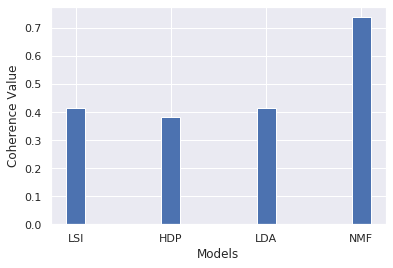

In [13]:
ntl=100
lsimodel = LsiModel(corpus=corpus, num_topics=ntl, id2word=dictionary)
ldamodel = LsiModel(corpus=corpus, num_topics=ntl, id2word=dictionary)
#mallet = LdaMallet(mallet_path, id2word=dictionary, num_topics=ntl, corpus=corpus)
#LDMallet = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet)
##########NMF############################
vectorizer = vsm.Vectorizer(tf_type="linear", apply_idf=True, idf_type="smooth", norm="l2",\
                                min_df=belo, max_df=abo)#tfidf
doc_term_matrix =vectorizer.fit_transform(lms)

nmfmodel = NMF( init="nndsvd", n_components=ntl ) 
doc_topic_matrix = nmfmodel.fit_transform( doc_term_matrix )#
H = nmfmodel.components_ # term weights relative to each of the k topics.
#to which topic is related the word
terms=vectorizer.terms_list
#############################################

lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]
#maltopics = [[word for word, prob in topic] for topicid, topic in LDMallet.show_topics(num_topics=ntl, formatted=False)]
#######GET TOPICS with KWs for NMF######################################

def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

nmftopics = []#descriptors is the other name
for topic_index in range(ntl):#10 is the no of topic words, as with the other models=10
    nmftopics.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( nmftopics[topic_index] )
 ##########################################################################   

lsi_coherence = CoherenceModel(topics=lsitopics, texts=lms, dictionary=dictionary, window_size=200).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics, texts=lms, dictionary=dictionary, window_size=200).get_coherence()
lda_coherence = CoherenceModel(topics=ldatopics, texts=lms, dictionary=dictionary, window_size=200).get_coherence()
#mallet_coherence = CoherenceModel(topics=maltopics, texts=lms, dictionary=dictionary, window_size=200).get_coherence()
nmf_coherence = CoherenceModel(topics=nmftopics, texts=lms, dictionary=dictionary, window_size=200).get_coherence()

def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence, nmf_coherence],
                   ['LSI', 'HDP', 'LDA', 'NMF'])

#### NMF performed best but gensim does not have NMF, so we go ahead w LDA

In [14]:
########################GENSIM MODELS#############################
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = LdaMallet(mallet_path, id2word=dictionary, corpus=corpus, num_topics=num_topics)
        #HdpModel(corpus=corpus, id2word=dictionary)
        #LdaMallet(mallet_path, id2word=dictionary, corpus=corpus,iterations=30 , num_topics=num_topics)
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        #LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        topics = [[word for word, prob in topic] for topicid, topic in model.show_topics(num_topics=num_topics, formatted=False)]
        coherencemodel = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v',window_size=200)
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

lmt=100; strt=10; stp=10

model_list, coherence_values = compute_coherence_values(dictionary, corpus=corpus, texts=lms, start=strt, limit=lmt, step=stp)

#### Show Graph

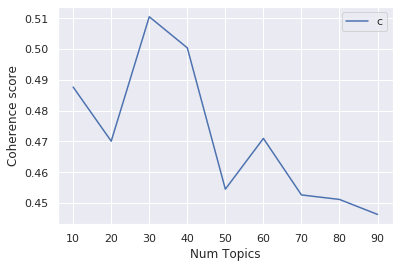

In [15]:
x = range(strt, lmt, stp)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show();

.55 is okay

.65 might be as good as it is going to get

.7 is nice


#### Select the optimal model and print the topics

In [16]:
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10,num_topics=50))

[(28,
  '0.043*"chancellor angela" + 0.040*"merkel" + 0.038*"angela merkel" + '
  '0.036*"angela" + 0.035*"chancellor angela merkel" + 0.034*"chancellor" + '
  '0.031*"german chancellor" + 0.017*"tumblr" + 0.010*"twitter" + '
  '0.006*"reddit"'),
 (30,
  '0.008*"adjacent" + 0.008*"face" + 0.008*"chocolate" + 0.007*"system" + '
  '0.007*"cute" + 0.006*"facial" + 0.006*"disk" + 0.006*"camera" + '
  '0.005*"technology" + 0.005*"station"'),
 (48,
  '0.008*"new" + 0.008*"service" + 0.007*"product" + 0.007*"technology" + '
  '0.006*"business" + 0.005*"customer" + 0.005*"mobile" + 0.005*"user" + '
  '0.005*"smartphone" + 0.005*"sale"'),
 (31,
  '0.008*"disk" + 0.006*"new" + 0.005*"multimedia" + 0.004*"japan" + '
  '0.004*"technology" + 0.004*"social" + 0.004*"source" + 0.004*"tokyo" + '
  '0.003*"release" + 0.003*"contact"'),
 (20,
  '0.007*"trump" + 0.006*"president" + 0.006*"donald trump" + 0.006*"donald" + '
  '0.005*"washington" + 0.005*"new" + 0.005*"senate" + 0.004*"turkey" + '
  '0.004

**LDA parameters :**

the number of topics 

the [distribution of the] number of words per topic is handled by beta

the [distribution of the] number of topics per document is handled by alpha


Assuming symmetric Dirichlet distributions, a low alpha value places more weight on having each document composed of only a few dominant topics (whereas a high value will return many more relatively dominant topics). Similarly, a low beta value places more weight on having each topic composed of only a few dominant words.

Also, an asymmetric alpha is helpful, where as an asymmetric beta is largely not.
Gensim: ’asymmetric’: Uses a fixed normalized asymmetric prior of 1.0 / topicno.
’auto’: Learns an asymmetric prior from the corpus, or you can 1D array of length equal to the number of expected topics that expresses our a-priori belief for the each topics’ probability. 


parameter selection:  Adopting the uniform Dirichlet priors
suggested by Steyvers and Griffiths (2007) (alpha=50/T = 6.25; beta = 0.01 for 2 <= T <= 10),


In [17]:
ntp=10
LDModel = LdaModel(corpus=corpus, num_topics=ntp, id2word=dictionary)
#mallet = LdaMallet(mallet_path, id2word=dictionary, num_topics=ntp, corpus=corpus)
#LDMallet = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet)

#### You can calculate coherence again if you want to check 

In [18]:
#cm = CoherenceModel(model=LDMallet,topn=ntp, corpus=corpus, texts=lms, dictionary=dictionary, coherence='c_v',window_size=200)
#cm.get_coherence()  # get coherence value

#### You can save your model then load it again

In [19]:
#start HERE
#LDMallet.save('LDMallet')
#LDMallet =  LdaModel.load('LDMallet')

### 3.3  Explore and improve your model


Although systematic, model selection procedures do not guarantee the best performing model. There still might be better performing models or we can improve our model. Performance is dependent upon several factors such as number of documents, document length, number of topics, sparsity, distance of topics and most importantly selection of keywords. Exploring the topics can point to some more cleaning efforts. For example, words like, new, york, times can come together to make a topic. This might point to an important topic but also to the name of a newspaper. Also, topics appearing in a few documents need to be removed 

Try to reduce vocabulary size. This helps an increase in the apparent content of the topic summaries. Add more stopwords if required.

Morphological conflation such as stemming or lemmatizing combines near-duplicate terms. However, to do this correctly requires normalization to counter the apparent improvements in evaluation metrics that would be produced by any vocabulary reduction technique. 
Stronger stemming treatments, those that more aggressively reduce  vocabulary size, improve model fit. However, much of this improvement can be accounted for by the reduction of the probability space of the model produced by a reduced vocabulary. 
Compared to stemming, lemmatization gives more readable results. 

Overfitting too many redundant topics dramatrically worsen the learning rate 



#### 3.3.1 Topic-word distribution

In [20]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    return terms

topic_kws= []
print(u'{:20} {}'.format(u'term', u'weight') + u'\n')
for i in range(ntp):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(LDModel,topic_number=i, topn=10, output=True )
#     print tmp[:5]
    topic_kws += [tmp[:5]]
    print

term                 weight

Topic 0 |---------------------

technology           0.007
new                  0.006
development          0.006
central news agency  0.005
system               0.005
ai                   0.004
government           0.004
industry             0.004
human                0.004
vehicle              0.004


<function print>

Topic 1 |---------------------

president            0.004
new                  0.004
china                0.004
u.s.                 0.004
government           0.004
technology           0.004
trade                0.004
economy              0.004
global               0.004
economic             0.004


<function print>

Topic 2 |---------------------

technology           0.008
industry             0.008
china                0.006
development          0.006
government           0.005
datum                0.005
business             0.005
market               0.005
new                  0.005
big                  0.005


<function print>

Topic 3 |---------------------

technology           0.007
new                  0.005
car                  0.005
industry             0.004
system               0.004
toyota               0.003
big                  0.003
autonomous           0.003
human                0.003
machine              0.003


<function print>

Topic 4 |---------------------

human                0.005
new                  0.005
university           0.004
ai                   0.004
technology           0.003
system               0.003
game                 0.003
computer             0.003
different            0.003
program              0.003


<function print>

Topic 5 |---------------------

new                  0.005
government           0.004
minister             0.004
technology           0.003
business             0.003
big                  0.003
large                0.003
official             0.003
system               0.003
european             0.003


<function print>

Topic 6 |---------------------

technology           0.009
business             0.007
new                  0.006
industry             0.006
ai                   0.005
service              0.005
research             0.005
development          0.005
global               0.005
product              0.004


<function print>

Topic 7 |---------------------

datum                0.006
new                  0.005
user                 0.005
ai                   0.005
social               0.004
facebook             0.004
technology           0.004
information          0.004
medium               0.004
service              0.004


<function print>

Topic 8 |---------------------

technology           0.007
new                  0.006
human                0.005
ai                   0.004
development          0.004
university           0.004
system               0.004
research             0.004
science              0.004
job                  0.004


<function print>

Topic 9 |---------------------

new                  0.007
technology           0.006
user                 0.004
system               0.004
ai                   0.004
available            0.004
machine              0.004
information          0.004
product              0.004
human                0.003


<function print>

In [21]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = LDModel.show_topics(formatted=False, num_topics=ntp)

#### You can plot the wordclouds for each topic 10 by 10. So to see next 10; topics1 =topics[10:20]


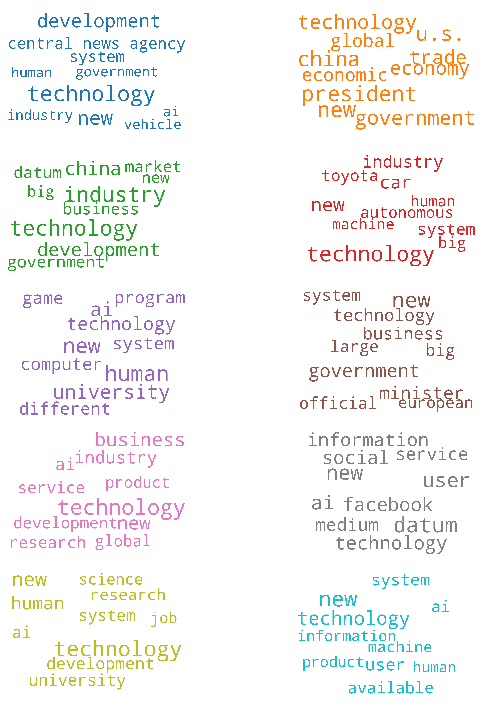

In [22]:
topics1 =topics[0:10]#does not plot more than 10, hence next ten , next ten iterate till no of topics
fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics1[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show();

#### Visualize with LDAVis

Computes topic frequencies, inter-topic distances, and projects topics onto a two-dimensional plane to represent their similarity to each other. It also loops through a grid of values of a tuning parameter, 

Larger topics are more frequent in the corpus.
Topics closer together are more similar, topics further apart are less similar.
When you select a topic, you can see the most representative words for the selected topic. This measure can be a combination of how frequent or how discriminant the word is. You can adjust the weight of each property using the slider.

λ controls how the terms are ranked for each topic, where terms are listed in decreasing of relevance, where the values near 1 give high relevance rankings to frequent terms within a given topic, whereas values of near zero give high relevance rankings to exclusive terms within this topic. 

Hovering over a word will adjust the topic sizes according to how representative the word is for the topic.

In [23]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(LDModel, corpus, dictionary=LDModel.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.027092  0.084888       1        1  14.593218
4     -0.079868 -0.065919       2        1  13.537264
1      0.092301 -0.051814       3        1  13.385972
8      0.002404 -0.009160       4        1  13.125663
9     -0.107192  0.046411       5        1  13.041250
7     -0.031443 -0.005794       6        1  11.770213
2      0.065924  0.034251       7        1   8.411232
3     -0.004487 -0.008801       8        1   4.511687
5      0.014206 -0.035275       9        1   4.426890
0      0.021063  0.011215      10        1   3.196612, topic_info=    Category         Freq         Term        Total  loglift  logprob
145  Default  4661.000000   technology  4661.000000  30.0000  30.0000
73   Default  2668.000000     industry  2668.000000  29.0000  29.0000
334  Default  2533.000000  development  2533.000000  28.0000  28.0000
65   Default  2071.000000   government  2071.000000  27.0000  27.0000
182  Default  1854.000000        china  1854.000000  26.0000  26.0000
..       ...          ...          ...          ...      ...      ...
78   Topic10    60.857208          job  1242.237061   0.4269  -6.0476
182  Topic10    64.329887        china  1854.393799   0.0818  -5.9921
395  Topic10    61.502769     software  1359.378784   0.3474  -6.0370
577  Topic10    60.369358   investment  1232.259033   0.4270  -6.0556
864  Topic10    60.867847        group  1746.779175   0.0863  -6.0474

[789 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4161      3  0.486783         abe
4161      4  0.078744         abe
4161      6  0.007159         abe
4161      9  0.415198         abe
504       2  0.030641     abusive
...     ...       ...         ...
738       6  0.554120  zuckerberg
738       7  0.024446  zuckerberg
738       8  0.081488  zuckerberg
738       9  0.016298  zuckerberg
738      10  0.008149  zuckerberg

[4652 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 2, 9, 10, 8, 3, 4, 6, 1])

#### 3.3.2 Document-Topic distribution

#### What is the Dominant topic and its percentage contribution in each document

Typically only one of the topics is dominant in one doc. The below code extracts this dominant topic for each doc and shows the weight of the topic and the keywords in a nicely formatted output.

format documents to get a datafrme including: Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Content', 'Title'. then transform this to a df df_dominant_topic including

'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'title' in the end, we'll be able to see which topics are dominat in the doxuments, will get the docs w highest topic % contribution, hence will be able to read them in detail.

In [24]:
df4=pd.read_csv('jap2.csv', encoding='utf8')

def format_topics_docs(ldamodel=LDModel, corpus=corpus, texts=lms, titles=df4.Title):
    # Init output
    doc_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                doc_topics_df = doc_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    doc_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    title = pd.Series(titles)
    doc_topics_df = pd.concat([doc_topics_df, contents, title], axis=1)
    return(doc_topics_df)

df_topic_docs_keywords = format_topics_docs(ldamodel=LDModel, corpus=corpus, texts=df4.Content, titles= df4.Title)
df_topic_docs_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Content,Title
0,8.0,0.5051,"technology, new, human, ai, development, unive...","Robots aren t replacing everyone, but a quarte...",Will robots take your job? Quarter of US worke...
1,2.0,0.2691,"technology, industry, china, development, gove...",BEIJING AP Skipped paying a fine in China? The...,China bars millions from travel for 'social cr...
2,9.0,0.9944,"new, technology, user, system, ai, available, ...","MOUNTAIN VIEW, Calif. AP Google put the spotli...",How Google aims to simplify your life with AI
3,7.0,0.5582,"datum, new, user, ai, social, facebook, techno...","Walmart will integrate Google Express, which a...",Google and Walmart team up to take on Amazon
4,7.0,0.3176,"datum, new, user, ai, social, facebook, techno...",Justin Welby was facing accusations of hypocri...,Archbishop of Canterbury is accused of hypocri...
...,...,...,...,...,...
7616,6.0,0.9672,"technology, business, new, industry, ai, servi...","BERLIN BUSINESS WIRE Jun 18, 2015 Johns Manvil...",Johns Manville Celebrates Inauguration of New ...
7617,1.0,0.9945,"president, new, china, u.s., government, techn...",U.S. Defense Secretary Jim Mattis pauses as he...,Pentagon chief says NKorea's nuclear pursuits ...
7618,9.0,0.9608,"new, technology, user, system, ai, available, ...",CHICAGO AP Following years of reformulating at...,McDonald's says most burgers now preservative-...
7619,9.0,0.5762,"new, technology, user, system, ai, available, ...",SAN FRANCISCO AP Facebook CEO Mark Zuckerberg ...,"Facebook unveils Quest, its new virtual-realit..."


#### '''Get dominant topics per each doc'''



In [25]:
# Format
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'title']

''' view texts  and dom tops for each doc'''
pd.set_option('display.max_colwidth', -1)
df_dominant_topic.loc[:5, ['Dominant_Topic', 'title']]

# Distribution of Dominant Topics in Each Document, no of docs with top i having as dom top 
dominant_topic_in_each_doc = df_dominant_topic.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()
# Distribution of Dominant Topics in Each Document, no of docs with top i having as dom top 
df_dominant_topic_in_each_doc

' view texts  and dom tops for each doc'

,Dominant_Topic,title
0,8.0,Will robots take your job? Quarter of US workers at risk
1,2.0,China bars millions from travel for 'social credit' offenses
2,9.0,How Google aims to simplify your life with AI
3,7.0,Google and Walmart team up to take on Amazon
4,7.0,Archbishop of Canterbury is accused of hypocrisy after slamming web giant Amazon for ‘leeching’ off taxpayers – as it emerges his Church holds a multi-million-pound stake in the retailer
5,8.0,"Robots could become CRIMINALS: Police may not be able to stop AI breaking the law, warn experts"


,Dominant_Topic,count
0,0.0,202
1,1.0,938
2,2.0,676
3,3.0,276
4,4.0,1126
5,5.0,273
6,6.0,1244
7,7.0,824
8,8.0,1010
9,9.0,1052


#### Distribution of Document Word Counts by Dominant Topic, is the topic in short or long docs?

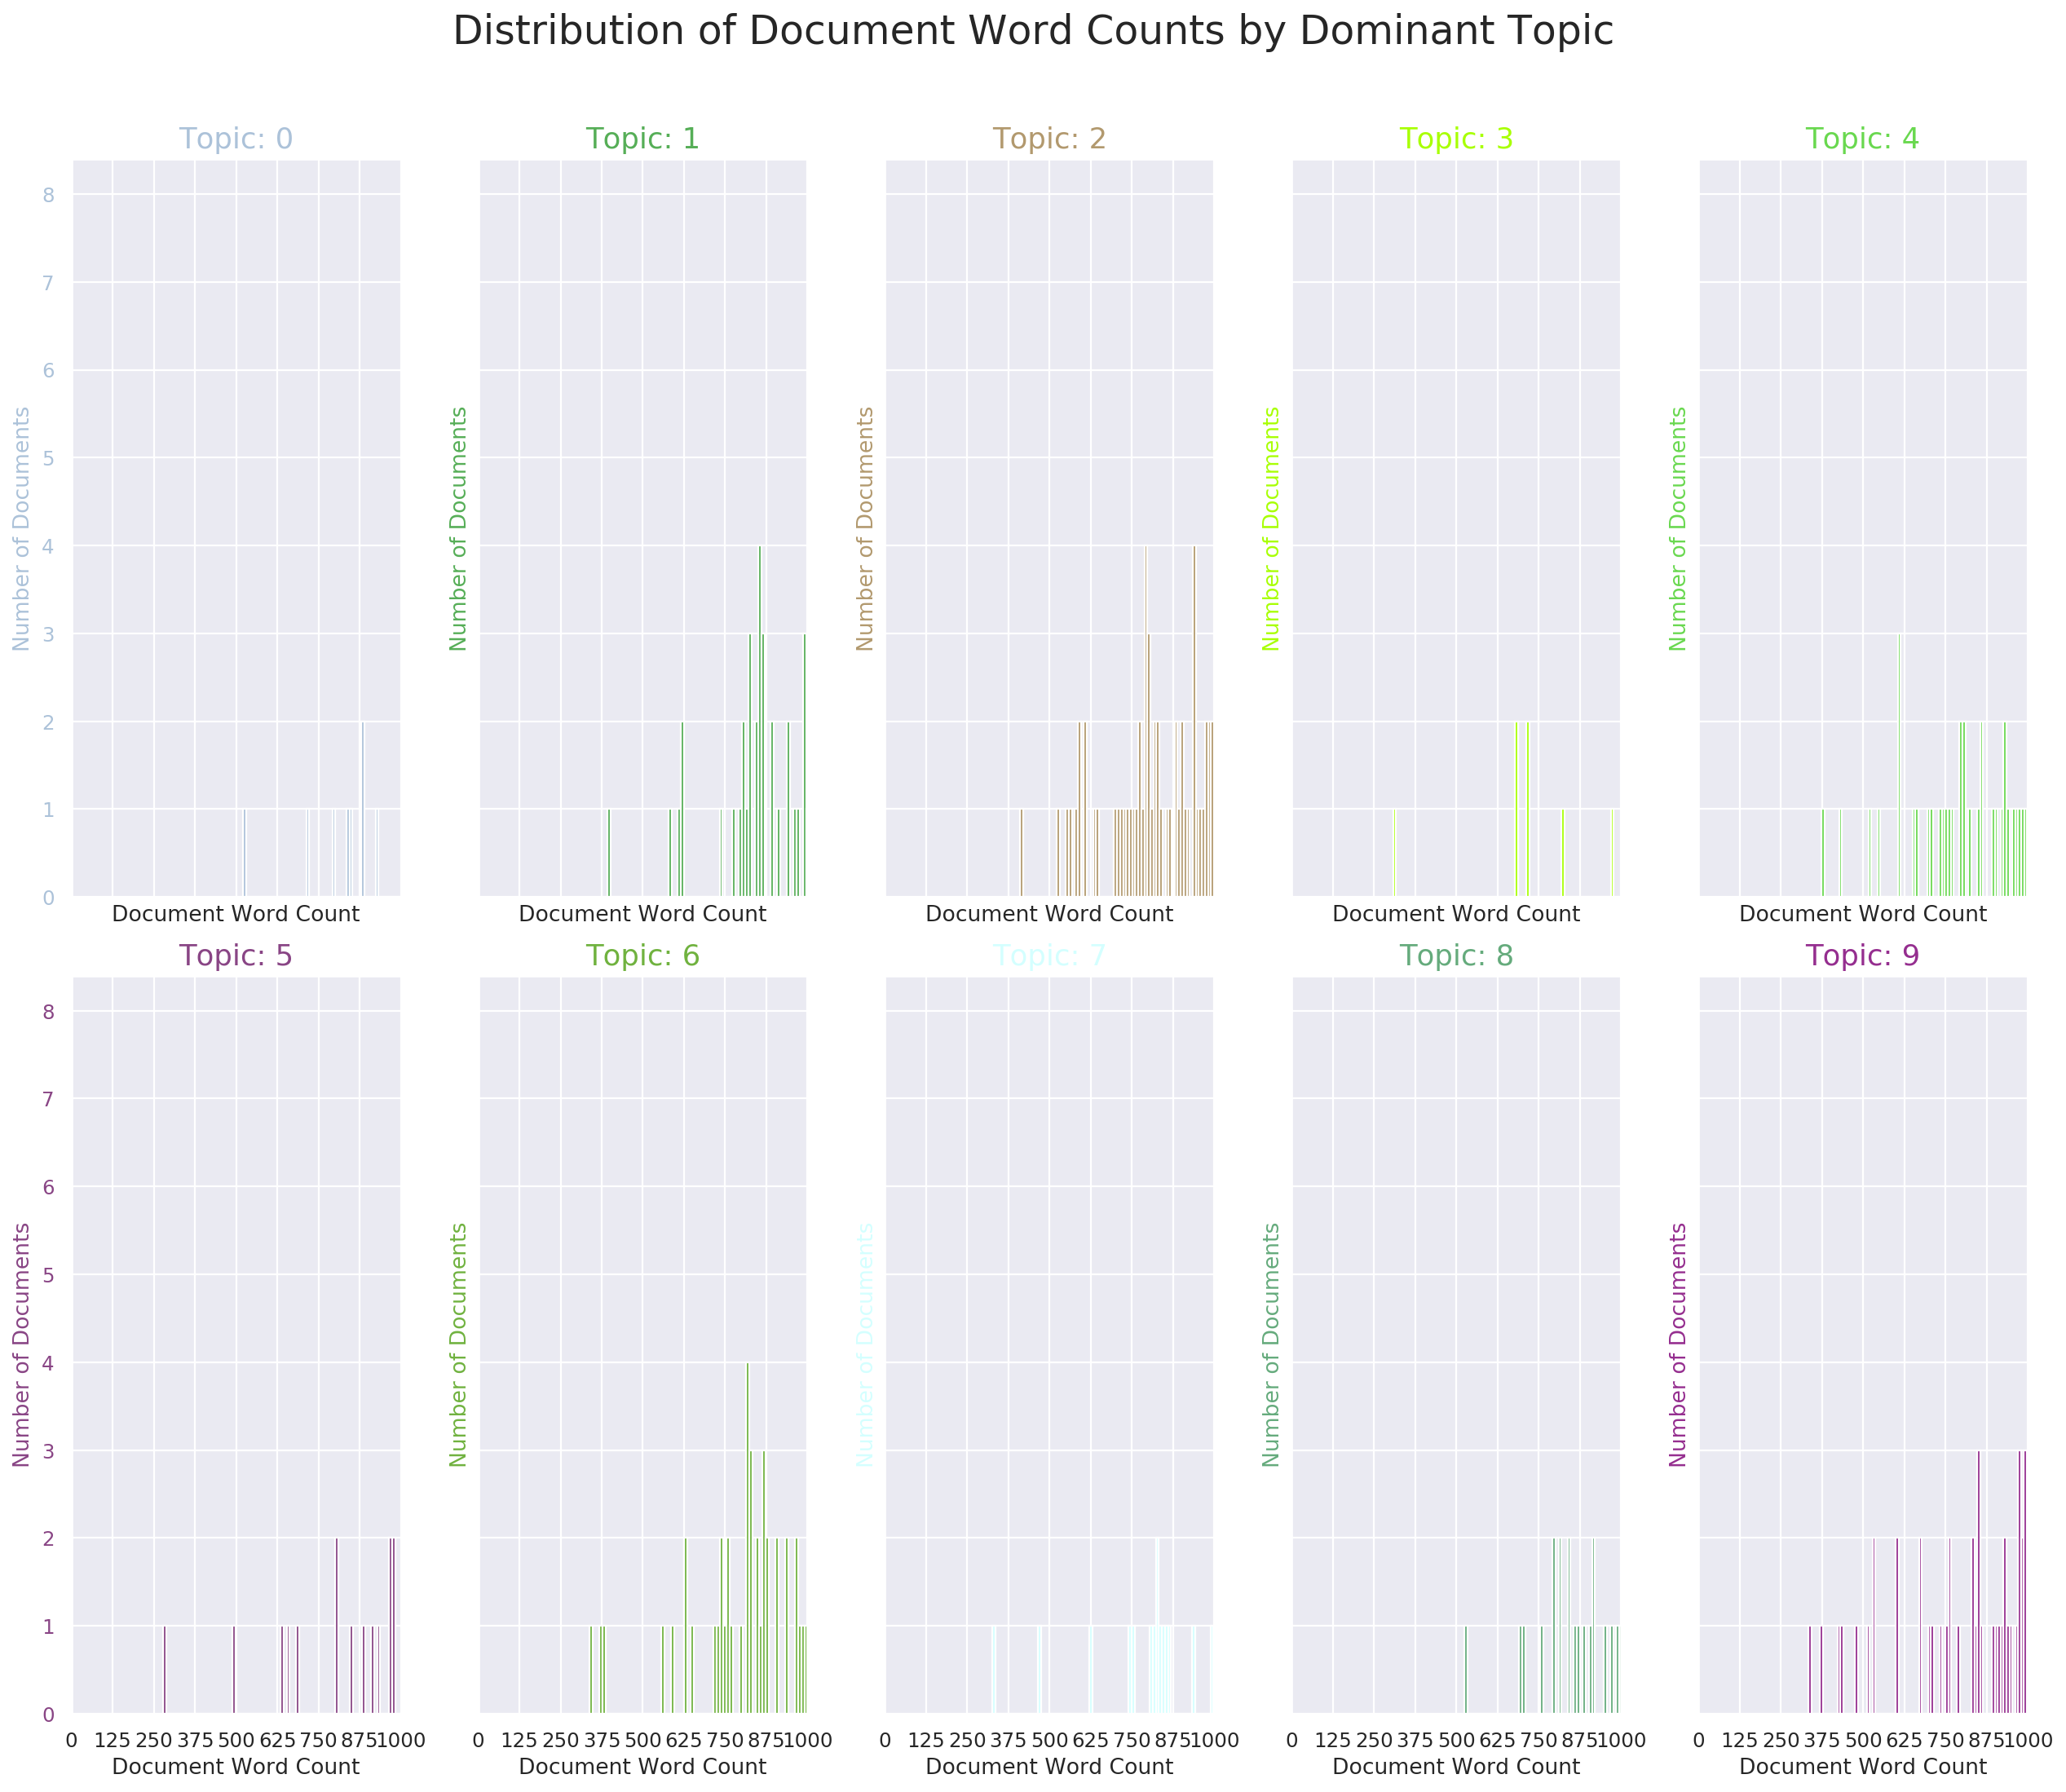

In [26]:
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
fig, axes = plt.subplots(2,5,figsize=(16,14), dpi=160, sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show();

#### What are the most discussed topics in the documents? distribution of no of docs to each topic?

df_top3words gets the top 3 words for labeliing the topic automatically

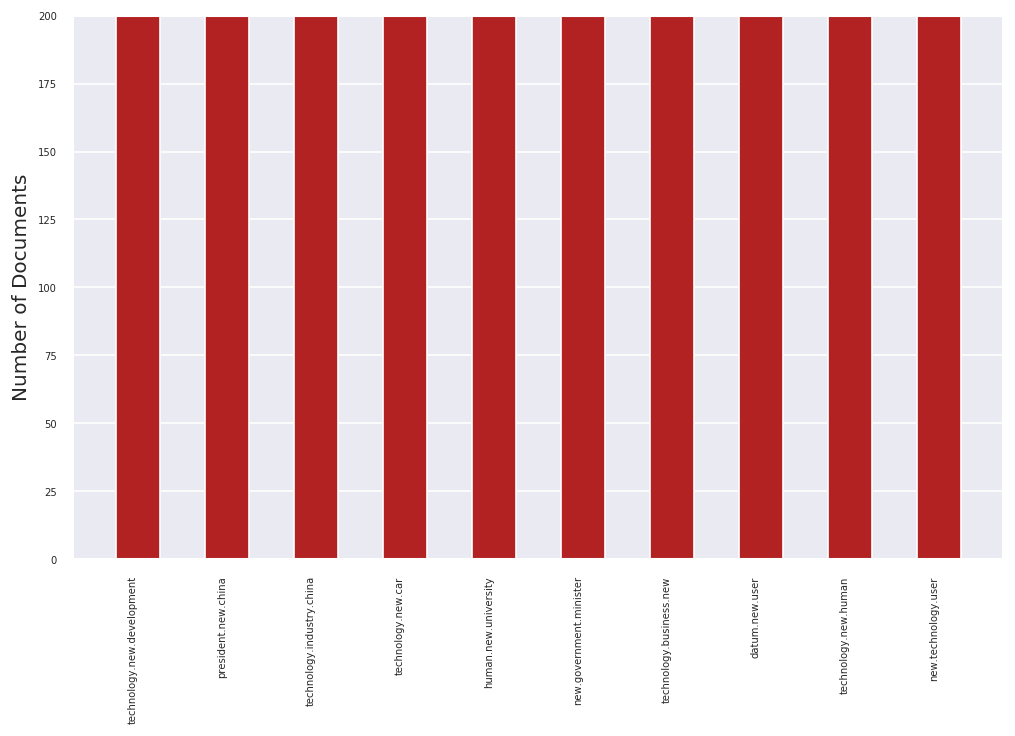

In [27]:
#Top 3 Keywords for each Topic, to see what the topics are abouut, as topi labels
topic_top3words = [(i, topic) for i, topics in LDModel.show_topics(formatted=False, num_topics=ntp) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg('.'.join)
df_top3words.reset_index(level=0,inplace=True)

fig, ax1 = plt.subplots(figsize=(10, 6), dpi=120)
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = ticker.FuncFormatter(lambda x, pos: df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 200)
ax1.tick_params(axis='both', which='major', labelsize=6, pad=4)
plt.xticks(rotation=90, ha='right')
plt.show();

### 3.3.3 Intrepret your topics

Deciding on the final model requires interpretative exercise. Topic modelling provides us only with the topic words and weights which can give us an intuition about but not the meaning of the topic. Hence, we need to retrieve the documents dominated by each topic and read them. This is required not only for sensible labelling of the topics but also identifying irrelevant topics. For example, names of the Country Presidents came as segregating topics in this research but were not related to AI context. Hence, we can exclude them. For the interpretative exercise, words representing a topic are examined together with the titles of the documents dominated by this topic. If this did not give straight forward understanding of the topic, then Gensim’s  automatic summarization feature is used. If none of these worked, then a deep reading of the documents is made

#### Find the most representative 5 documents for each topic

you'll get: 'Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text", 'title', hence will be able see the top docs

In [28]:
# Group top 5 docs under each topic
doc_topics_sorteddf_mallet = pd.DataFrame()

doc_topics_outdf_grpd = df_topic_docs_keywords.groupby('Dominant_Topic')

for i, grp in doc_topics_outdf_grpd:
    doc_topics_sorteddf_mallet = pd.concat([doc_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False)], 
                                            axis=0)
# Reset Index    
doc_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
doc_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text", 'title']

#### see the topic kws and doc titles for topic

In [29]:
tn=9 #which topic docs you want to see?
cln ='title' # title  "Keywords"   Text# what do you want to see?
hm = 5# how many docs do you want to see
slct = doc_topics_sorteddf_mallet.loc[doc_topics_sorteddf_mallet['Topic_Num'] == tn-1]

x= slct.loc[:, ["Topic_Perc_Contrib",cln]].head(hm)

topics[tn]
for txt in x.title:
    pprint(txt)# word_count, ratio

(9,
 [('new', 0.0074386825),
  ('technology', 0.0055920086),
  ('user', 0.004470622),
  ('system', 0.004143432),
  ('ai', 0.0040835887),
  ('available', 0.0040223096),
  ('machine', 0.0037070839),
  ('information', 0.0036099337),
  ('product', 0.0035208014),
  ('human', 0.003453506)])

'The gender code: Will women program the future?'
'Workforce in the age of automation'
('         Swarming attack drones could soon be real weapons for the '
 'military     ')
('Nilekani is right: Jobs won’t exist if India fails to reskill for automation '
 'era  ')
(' Artificial intelligence has arrived, but Australian businesses are not '
 'ready for it ')


#### summaries of the topic docs

In [30]:
cln ='Text' # title  "Keywords"   Text# what do you want to see?
slct = doc_topics_sorteddf_mallet.loc[doc_topics_sorteddf_mallet['Topic_Num'] == tn-1]
x= slct.loc[:, ["Topic_Perc_Contrib",cln]].head(hm)

from gensim.summarization import summarize, keywords
for txt in x.Text:
    pprint(summarize(txt, ratio=.1))# word_count, ratio

('The country is facing a shortage of software engineers a resource critical '
 'to future competitiveness but there is a largely untapped group whose '
 'expertise could close the gap women.The Journal spoke with three industry '
 'leaders Chiaki Narusawa, director of not_for_profit organization NPO Women '
 'Who Code Tokyo, Yan Fan, co_founder of start_up Code Chrysalis, and Reimi '
 'Dallyn, principal at Fusion Systems about the role of women in '
 'programming.THE SITUATION Companies in Japan are beginning to look abroad '
 'for talent.\n'
 'A large part of this means making mistakes, something Japanese society is '
 'notoriously fearful of in contrast with the United States where, she '
 'explained, people are taught from a young age that failure is okay.It s no '
 'secret that the key to growing the number of software engineers in Japan is '
 'education, both at a higher level and at earlier stages.\n'
 'Dallyn believes it is a skill that also helps with logical thinking.GLOBAL '

#### See the whole content

In [31]:
for txt in x.Text:
    pprint(txt)# word_count, ratio

('You may not immediately associate computer science or engineering with '
 'women. But as far back as 1815, women were pioneers of technology. The world '
 's first computer programmer, by many accounts, was London_born Ada Lovelace, '
 'who created the first algorithm performed by Charles Babbage s mechanical '
 'computer.Despite this, men have since dominated computer programming a fact '
 'that is clearer in Japan than perhaps anywhere.Japanese society is in the '
 'throes of aging, bringing with it a candidate_short job market. The country '
 'is facing a shortage of software engineers a resource critical to future '
 'competitiveness but there is a largely untapped group whose expertise could '
 'close the gap women.The Journal spoke with three industry leaders Chiaki '
 'Narusawa, director of not_for_profit organization NPO Women Who Code Tokyo, '
 'Yan Fan, co_founder of start_up Code Chrysalis, and Reimi Dallyn, principal '
 'at Fusion Systems about the role of women in progra

#### Doc Chart Colored by Topic 
Each word in the document is representative of one of the all topics. Let’s color each word in the given documents 
by the topic id it is attributed to.

In [32]:
'''
https://markroxor.github.io/gensim/static/notebooks/topic_methods.html
'''
def color_words(model, doc):
    # make into bag of words
    doc = model.id2word.doc2bow(doc)
    # get word_topics
    doc_topics, word_topics, phi_values = model.get_document_topics(doc, per_word_topics=True)
    # color-topic matching
    colormap = np.array([color for name, color in mcolors.XKCD_COLORS.items()])
    x =list(range(0,ntp))
    y= colormap[0:ntp]
    topic_colors = dict(zip(x,y))
    # set up fig to plot
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    # a sort of hack to make sure the words are well spaced out.
    word_pos = 1/len(doc)
    
    # use matplotlib to plot words
    for word, topics in word_topics:
        ax.text(word_pos, 0.8, model.id2word[word],
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=20, color=topic_colors[topics[0]],  # choose just the most likely topic
                transform=ax.transAxes)
        word_pos += 0.2 # to move the word for the next iter

    ax.set_axis_off()
    plt.axis('off')
    plt.grid(b=None)
    plt.show()

'\nhttps://markroxor.github.io/gensim/static/notebooks/topic_methods.html\n'

#### enter the doc no you want to visualize

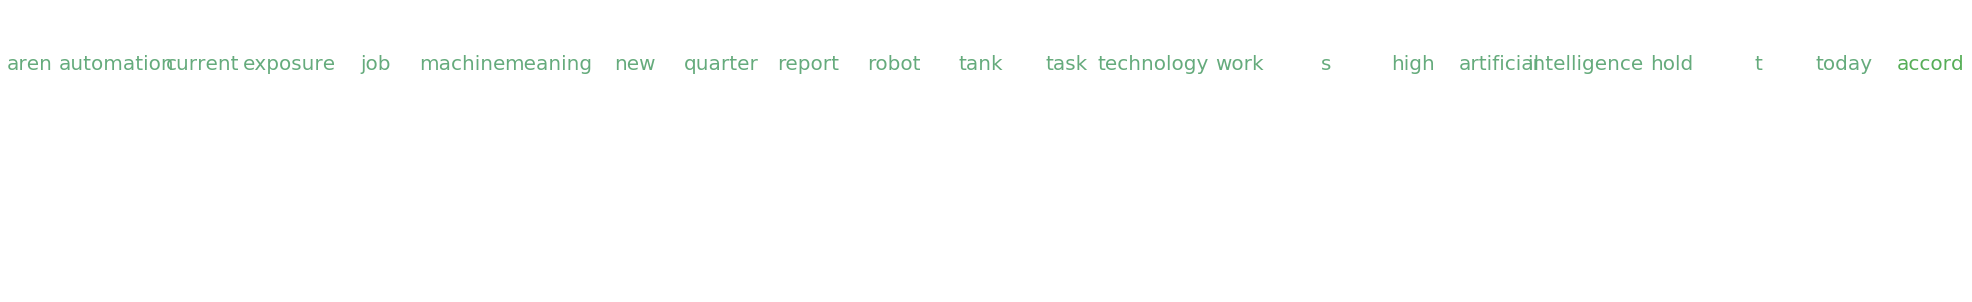

In [33]:
doc_no=1

text=summarize(df4.Content[1-1], ratio=.1)

nl =spacy.load('en', disable=('vectors', 'textcat', "parser", "ner"))
doc = [w.lemma_ for w in nl(text) if not w.is_stop and  not w.is_punct and not w.like_num\
       and  w.text !='\n' ]
color_words(LDModel, doc)

#### If you want to manually label your topics according to your interpretation:

top_labels = {0: 'Statistics', 1:'Numerical Analysis', 2:'Online Learning', 3:'Deep Learning'}


### 3.4 Visualize if the topics are in well seggregating clusters

Finally, to check if  we have good segregating topics, we need to visualize the clusters of documents in a reduced dimensional (2D or 3D) space. This is usually done by principal component analysis, but this research used t-SNE (t-distributed stochastic neighbour embedding) algorithm for this. This method  is particularly well suited for the visualization of high-dimensional datasets. Contrary to PCA,  it is not a mathematical technique but a probabilistic one. It looks at the original data and looks at how to best represent this data using less dimensions by matching the data  similarities with the ones estimated by the algorithm. Examining the plot also can give an idea about merging some topics.

In [34]:
'''TSNE PLOT
https://shuaiw.github.io/2016/12/22/topic-modeling-and-tsne-visualzation.html

'''

def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document. i.e. topic_weights, gives a doc by topic matrix
    """
    topic_weights = lda_model.get_document_topics(document, minimum_probability=0)
    topic_weights = np.array(topic_weights)
    return topic_weights[:,1]


arr  = list(map(lambda doc:
                          document_to_lda_features(LDModel, doc),
                          corpus))

'TSNE PLOT\nhttps://shuaiw.github.io/2016/12/22/topic-modeling-and-tsne-visualzation.html\n\n'

In [35]:
arr = pd.DataFrame(arr).fillna(0)# topic weights
# Keep the well separated points (optional)
doc_top_mat=arr.values

# Dominant topic number in each doc
_lda_keys = list(np.argmax(doc_top_mat, axis=1))#topic numbers
num_example = len(doc_top_mat)
topic_summaries= df_top3words['words'].values

# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.5, init='pca')
# 35-D -> 2-D
tsne_lda = tsne_model.fit_transform(doc_top_mat)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7621 samples in 0.006s...
[t-SNE] Computed neighbors for 7621 samples in 1.018s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7621
[t-SNE] Computed conditional probabilities for sample 2000 / 7621
[t-SNE] Computed conditional probabilities for sample 3000 / 7621
[t-SNE] Computed conditional probabilities for sample 4000 / 7621
[t-SNE] Computed conditional probabilities for sample 5000 / 7621
[t-SNE] Computed conditional probabilities for sample 6000 / 7621
[t-SNE] Computed conditional probabilities for sample 7000 / 7621
[t-SNE] Computed conditional probabilities for sample 7621 / 7621
[t-SNE] Mean sigma: 0.003639
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.853363
[t-SNE] KL divergence after 1000 iterations: 0.862959


In [36]:
#### bu plot cikmiyor

import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool

title = '35 LDA viz'
colormap = np.array([color for name, color in mcolors.XKCD_COLORS.items()])

plot_lda = bp.figure(plot_width=1400, plot_height=1100,
                     title=title,
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

    
plot_lda.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1],
                 color=colormap[_lda_keys][:num_example],
              )

topic_coord = np.empty((np.array(doc_top_mat).shape[1], 2)) * np.nan
for topic_num in _lda_keys:
  if not np.isnan(topic_coord).any():
    break
  topic_coord[topic_num] = tsne_lda[_lda_keys.index(topic_num)]

# plot crucial words
for i in range(np.array(doc_top_mat).shape[1]):
  plot_lda.text(topic_coord[i, 0], topic_coord[i, 1], [topic_summaries[i]])

output_file("foo.html")
show(plot_lda);

#### To visualize dominant topics according to an external category (source, country, year, author......)

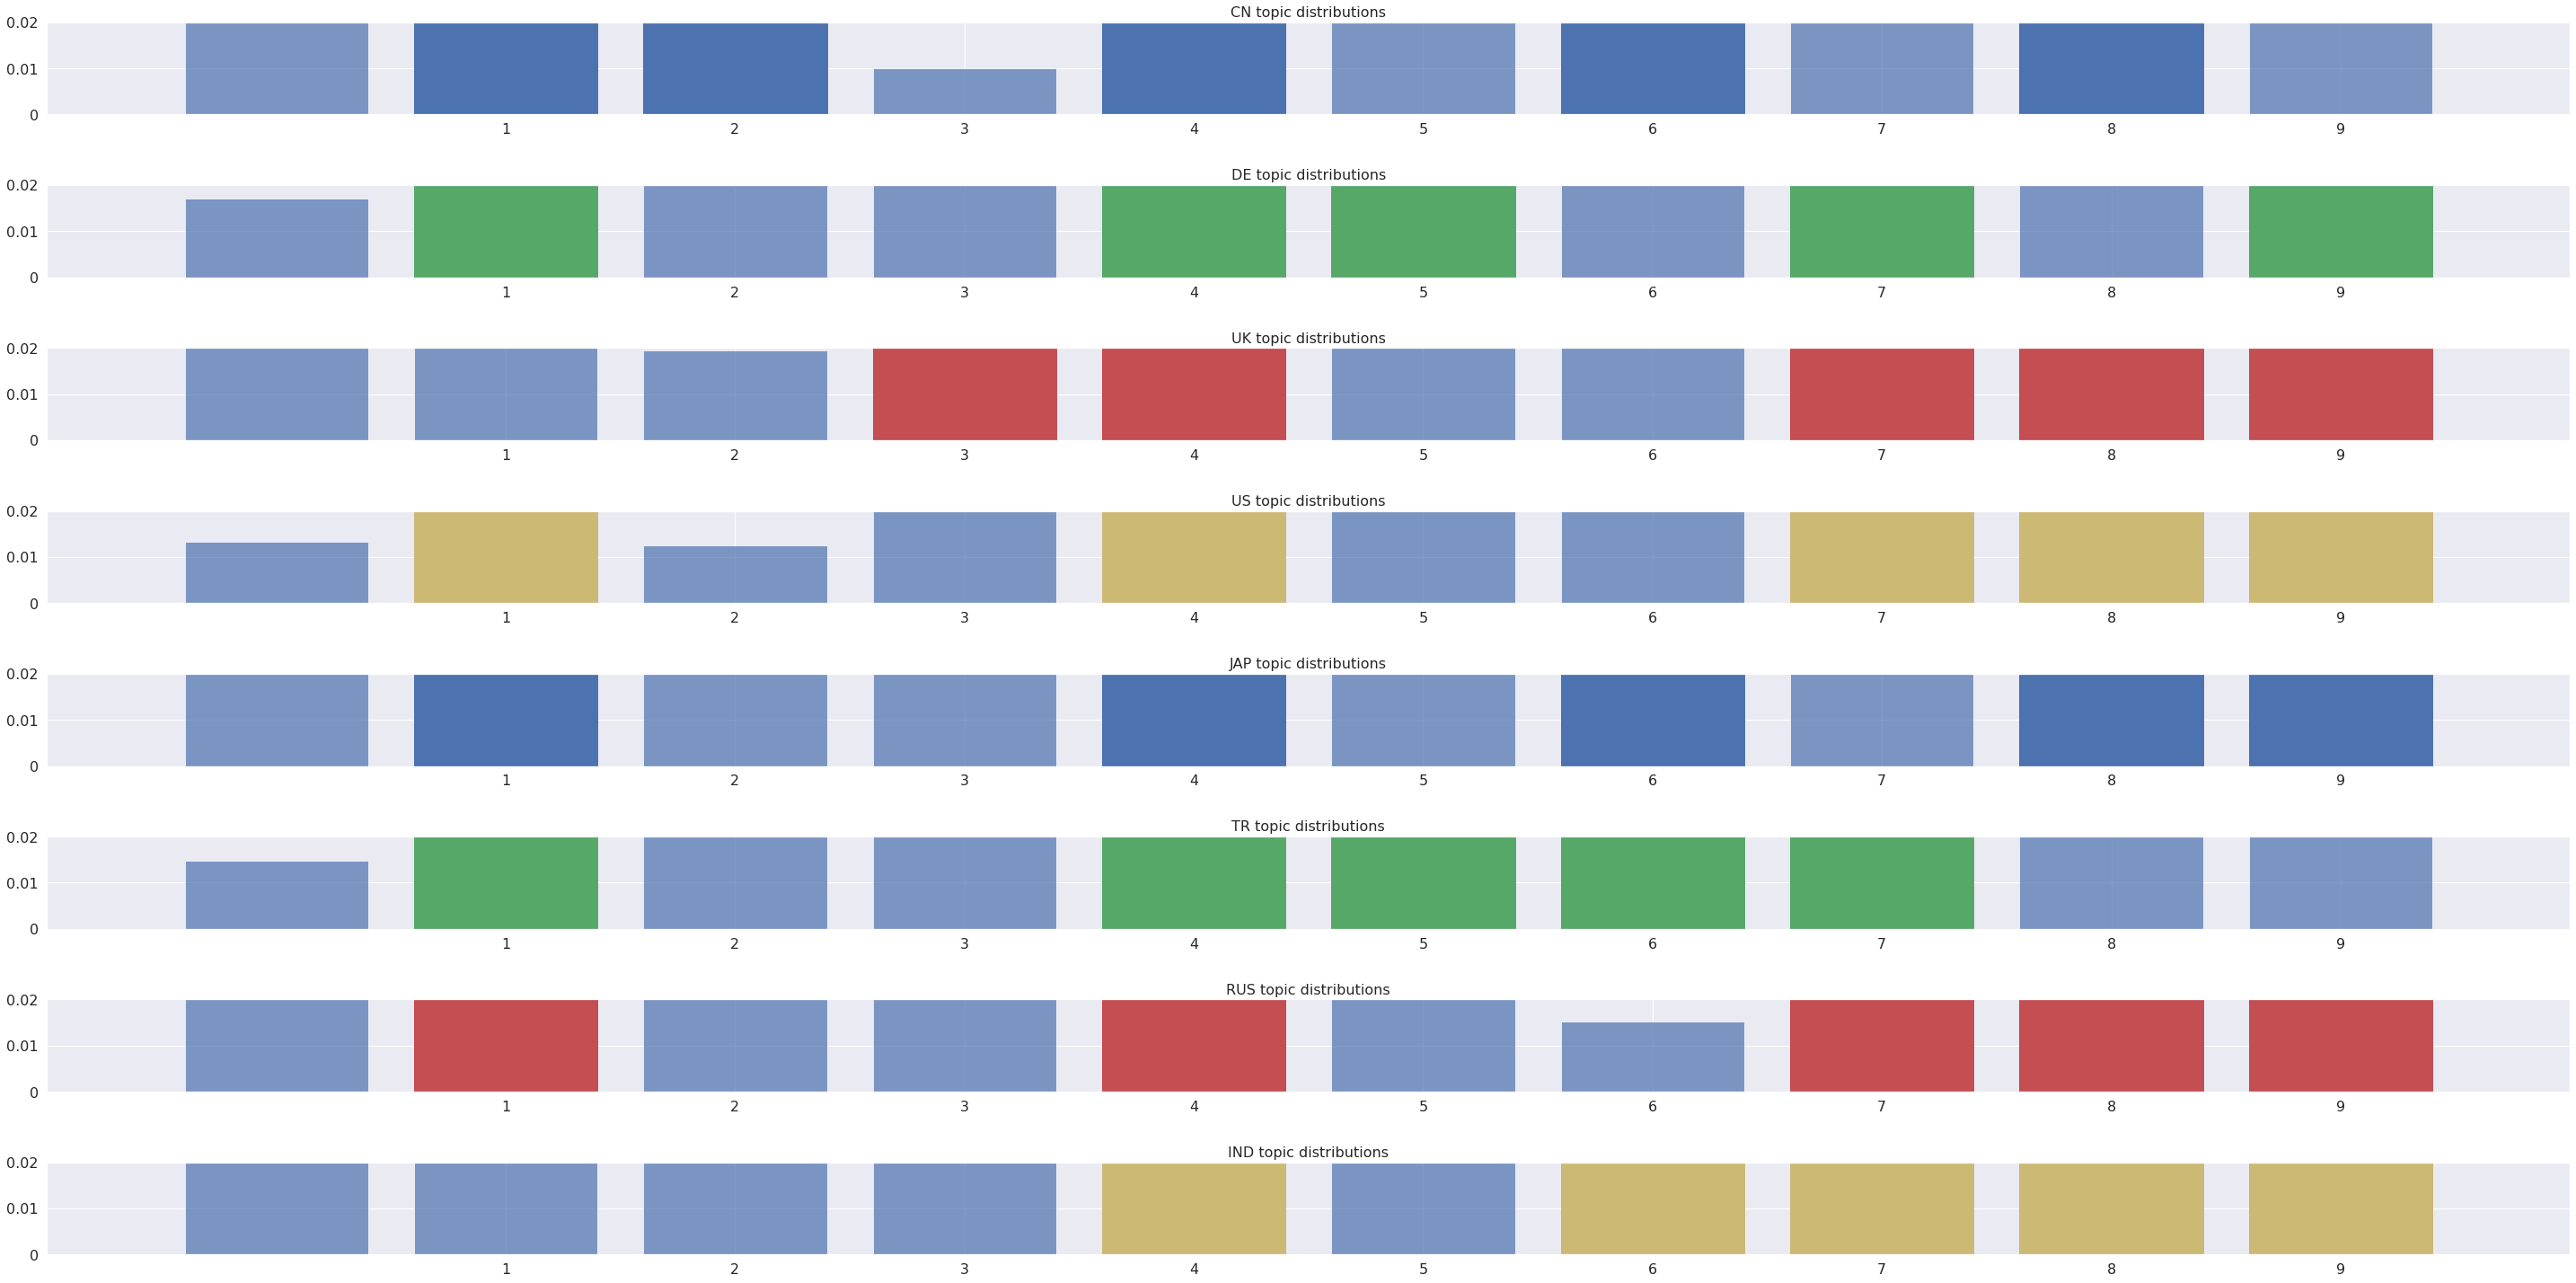

In [37]:
df4['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDModel, doc),
                                      corpus))
CN_topic_distribution = df4.loc[df4.country == 'cn', 'lda_features'].mean()
DE_topic_distribution = df4.loc[df4.country == 'ger', 'lda_features'].mean()
UK_topic_distribution = df4.loc[df4.country == 'uk', 'lda_features'].mean()
US_topic_distribution = df4.loc[df4.country == 'us', 'lda_features'].mean()
JAP_topic_distribution = df4.loc[df4.country == 'jap', 'lda_features'].mean()
TR_topic_distribution = df4.loc[df4.country == 'tr', 'lda_features'].mean()
RUS_topic_distribution = df4.loc[df4.country == 'rus', 'lda_features'].mean()
IND_topic_distribution = df4.loc[df4.country == 'ind', 'lda_features'].mean()

fig, [ax1,ax2,ax3, ax4, ax5, ax6, ax7, ax8] = plt.subplots(8,1,figsize=(40,20))

nr_top_bars = 5

ax1.set_title("CN topic distributions", fontsize=16)
ax2.set_title("DE topic distributions", fontsize=16)
ax3.set_title("UK topic distributions", fontsize=16)
ax4.set_title("US topic distributions", fontsize=16)
ax5.set_title("JAP topic distributions", fontsize=16)
ax6.set_title("TR topic distributions", fontsize=16)
ax7.set_title("RUS topic distributions", fontsize=16)
ax8.set_title("IND topic distributions", fontsize=16)


for ax, distribution, color in zip([ax1,ax2,ax3, ax4, ax5, ax6, ax7, ax8],
                                   [CN_topic_distribution,DE_topic_distribution,UK_topic_distribution, US_topic_distribution, JAP_topic_distribution,\
                                   TR_topic_distribution,RUS_topic_distribution,IND_topic_distribution],
                                   ['b','g','r', 'y','b','g','r', 'y']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, ntp)
    ax.set_xticks(range(int(ntp/10),ntp,int(ntp/10)))
    ax.set_xticklabels(range(int(ntp/10),ntp,int(ntp/10)), fontsize=16)
    ax.set_ylim(0,0.02)
    ax.set_yticks([0,0.01,0.02])
    ax.set_yticklabels([0,0.01,0.02], fontsize=16)

fig.tight_layout(h_pad=3.);

# THANK YOU! 

If you want to ask any questions, my E-mail:
    a.k.suerdem@lse.ac.uk